# Lab1. Custom Object Detection with SageMaker built-in algorithm

In this lab, you will build a model to recognize license plate area from images that we generated in Lab0.  
You can run all notebook cells at once.  
It may **take 25~30 minutes** in total.


## Preparing Object Detection data

* Divide train and valdiation data from generated images
* od, od/train, od/validation folders will be used to store the divided data

In [2]:
import os 

In [3]:
!rm -fR od
!mkdir od od/od-train od/od-train_annotation od/od-validation od/od-validation_annotation

In [4]:
jsons = os.listdir('gen/gen-tags')
print ('There are {:,} images have annotation files'.format(len(jsons)))

There are 10,000 images have annotation files


* Define the number of train/valdiation images

In [5]:
n_samples = len(jsons)
n_val = 5000 if n_samples > 25000 else round(n_samples * 0.2)
n_train = n_samples - n_val
print('{:,} images will be used for training, and {:,} images will be used for validation.'.format(n_train, n_val))

8,000 images will be used for training, and 2,000 images will be used for validation.


* Move images and annotation files to od-train and od-validation folders  
 (Cropped-imgs and nums-tags files are not moved.)

In [6]:
import shutil

train_jsons = jsons[:n_train]
val_jsons = jsons[n_train:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './gen/gen-imgs/'+i.split('.')[0]+'.png'
    shutil.copy(image_file, './od/od-train/')
    shutil.copy('./gen/gen-tags/'+i, './od/od-train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './gen/gen-imgs/'+i.split('.')[0]+'.png'
    shutil.copy(image_file, './od/od-validation/')
    shutil.copy('./gen/gen-tags/'+i, './od/od-validation_annotation/')

* check the copy result

In [7]:
print('there are {:,} files in gen/gen-imgs folder.'.format(len(os.listdir('gen/gen-imgs'))))
print('there are {:,} files in gen/gen-tags folder.'.format(len(os.listdir('gen/gen-tags'))))
print('there are {:,} files in od/od-train folder.'.format(len(os.listdir('od/od-train'))))
print('there are {:,} files in od/od-train_annotation folder.'.format(len(os.listdir('od/od-train_annotation'))))
print('there are {:,} files in od/od-validation folder.'.format(len(os.listdir('od/od-validation'))))
print('there are {:,} files in od/od-validation_annotation folder.'.format(len(os.listdir('od/od-validation_annotation'))))

there are 10,000 files in gen/gen-imgs folder.
there are 10,000 files in gen/gen-tags folder.
there are 8,000 files in od/od-train folder.
there are 8,000 files in od/od-train_annotation folder.
there are 2,000 files in od/od-validation folder.
there are 2,000 files in od/od-validation_annotation folder.


## Upload the data to S3

* Set the SageMaker Session to upload data to S3

In [8]:
from PIL import Image
import json
import matplotlib.image as mpimg

In [9]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::578948193120:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


* Upload files to S3
* It may take several minutes **(5 minutes for 10,000 images)**

In [10]:
bucket = sess.default_bucket() 
prefix = 'anpr'

In [11]:
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'od/od-train')
s3_validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'od/od-validation')
s3_train_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'od/od-train_annotation')
s3_validation_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'od/od-validation_annotation')

In [18]:
%%time
!aws s3 rm {s3_train_data} --recursive --only-show-errors
!aws s3 rm {s3_validation_data} --recursive --only-show-errors
!aws s3 rm {s3_train_annotation} --recursive --only-show-errors
!aws s3 rm {s3_validation_annotation} --recursive --only-show-errors

CPU times: user 686 ms, sys: 95.8 ms, total: 781 ms
Wall time: 55.7 s


In [19]:
%%time
!aws s3 cp od/od-train {s3_train_data} --include "*_0.png" --recursive --only-show-errors
!aws s3 cp od/od-train {s3_train_data} --include "*_1.png" --recursive --only-show-errors
!aws s3 cp od/od-validation {s3_validation_data} --recursive --only-show-errors
!aws s3 cp od/od-train_annotation {s3_train_annotation} --recursive --only-show-errors
!aws s3 cp od/od-validation_annotation {s3_validation_annotation} --recursive --only-show-errors

CPU times: user 1.9 s, sys: 364 ms, total: 2.26 s
Wall time: 2min 35s


* Check the upload result 

In [20]:
!aws s3 ls {s3_train_data}/ |wc -l
!aws s3 ls {s3_validation_data}/ |wc -l
!aws s3 ls {s3_train_annotation}/ |wc -l
!aws s3 ls {s3_validation_annotation}/ |wc -l

8000
2000
8000
2000


In [21]:
s3_output_location = 's3://{}/{}/od-output'.format(bucket, prefix)
print(s3_output_location)
print(s3_train_data)
print(s3_validation_data)
print(s3_train_annotation)
print(s3_validation_annotation)

s3://sagemaker-us-east-1-578948193120/anpr/od-output
s3://sagemaker-us-east-1-578948193120/anpr/od/od-train
s3://sagemaker-us-east-1-578948193120/anpr/od/od-validation
s3://sagemaker-us-east-1-578948193120/anpr/od/od-train_annotation
s3://sagemaker-us-east-1-578948193120/anpr/od/od-validation_annotation


## Training with built-in algorithm
* Prepare SageMaker built-in Object Detection algorithm container

In [23]:
from sagemaker.amazon.amazon_estimator import get_image_uri

#training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
training_image = sagemaker.image_uris.retrieve('object-detection', sess.boto_region_name)
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


* Define Object Detection Estimator and Hyperparameters
* Refer to SageMaker Estimator API -> https://sagemaker.readthedocs.io/en/stable/estimators.html
* Note that we set parameters as below:
    * train_instance_type: ml.p3.2xlarge
    * **base_network: resnet-50**
    * **use_transfer_model: True**
    * epochs: 10
    * mini_batch_size: 64
    * learning_rate: 0.001
    

In [24]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.p3.2xlarge',
                                         volume_size = 30,
                                         max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         tags=[{"Key":"anpr","Value":"anpr-plate detection"}],
                                         sagemaker_session=sess)

In [25]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             mini_batch_size=64,
                             epochs=10,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='adam',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=n_train)

* Pass the channel of S3 paths as a dictionary to the Estimator
* Ref to Sessions -> https://sagemaker.readthedocs.io/en/stable/session.html#sagemaker.session.s3_input

In [26]:
train_data = sagemaker.inputs.TrainingInput(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.inputs.TrainingInput(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.inputs.TrainingInput(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

* Start the training.
* **It may take 15~20 minutes.**

In [27]:
%%time
od_model.fit(inputs=data_channels, logs=True)

2021-07-14 10:05:54 Starting - Starting the training job...
2021-07-14 10:06:18 Starting - Launching requested ML instancesProfilerReport-1626257154: InProgress
.........
2021-07-14 10:07:38 Starting - Preparing the instances for training.........
2021-07-14 10:09:19 Downloading - Downloading input data..................
2021-07-14 10:12:20 Training - Downloading the training image...
2021-07-14 10:12:41 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[07/14/2021 10:12:46 INFO 140169897174848] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold': '0.45', 'num_training

## Inference Object Detection

* Deploy trained model to SageMaker endpoint
* You can add Elastic Inference(EI, adding GPU power) by using 'accelerator_type' parameter
* Refer to types of EI asselerator below:
    * https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ei.html

In [28]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.c5.xlarge')
#                                 accelerator_type='ml.eia2.medium'

-------------!

* Check the endpoint name

In [29]:
print(object_detector.endpoint_name)

object-detection-2021-07-14-10-30-28-918


* Define bounding box visualization function 

In [30]:
import matplotlib.pyplot as plt
def visualize_detection(img_file, dets, code, thresh=0.6):
        import random
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = x0 * width
            ymin = y0 * height
            xmax = x1 * width
            ymax = y1 * height
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            #if classes and len(classes) > cls_id:class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(code, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        plt.show()

* Test licence plate detection of 10 sample image 

In [31]:
test_imgs = os.listdir('od/od-validation')
threshold = 0.4

{'prediction': [[0.0, 0.9999996423721313, 0.23210397362709045, 0.2041102647781372, 0.7505195140838623, 0.7915489673614502]]}


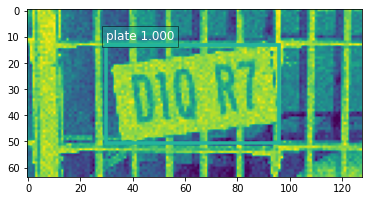

{'prediction': [[0.0, 0.9999995231628418, 0.2115173637866974, 0.2377852201461792, 0.7911320924758911, 0.7446088790893555]]}


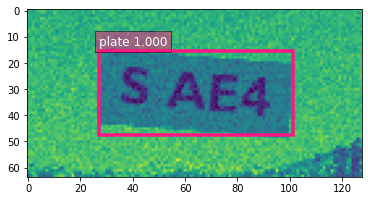

{'prediction': [[0.0, 0.9999908208847046, 0.28469815850257874, 0.1945822536945343, 0.719437837600708, 0.7783892154693604]]}


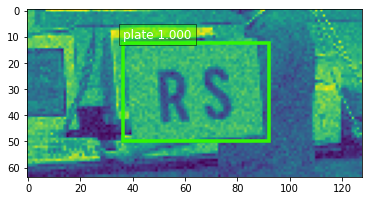

{'prediction': [[0.0, 0.9999979734420776, 0.2774236798286438, 0.17569464445114136, 0.7169777750968933, 0.7873895764350891]]}


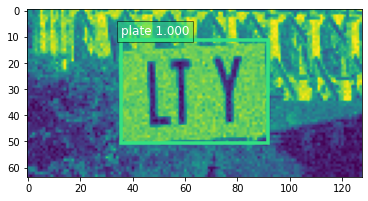

{'prediction': [[0.0, 0.9999629259109497, 0.08666124939918518, 0.1266169548034668, 0.9329735040664673, 0.8423988819122314]]}


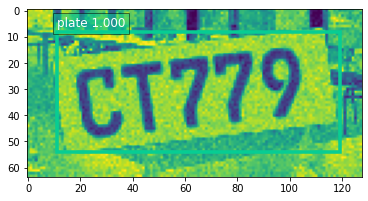

{'prediction': [[0.0, 0.9999967813491821, 0.24297066032886505, 0.17204412817955017, 0.7327150702476501, 0.7633954286575317]]}


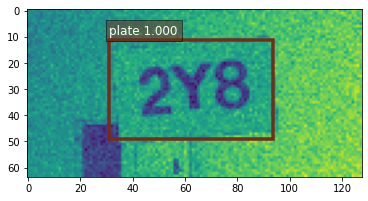

{'prediction': [[0.0, 0.9999998807907104, 0.22602584958076477, 0.14390042424201965, 0.7858144044876099, 0.8319202661514282]]}


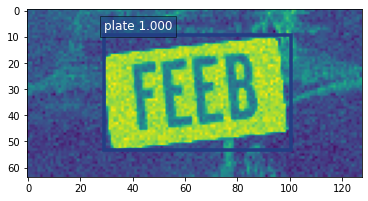

{'prediction': [[0.0, 0.9999998807907104, 0.1564038097858429, 0.13369989395141602, 0.8754045963287354, 0.8624588847160339]]}


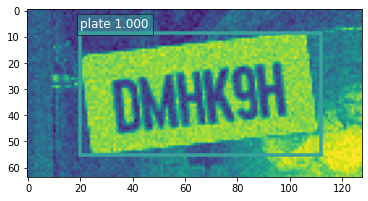

{'prediction': [[0.0, 0.999984860420227, 0.11124354600906372, 0.09923845529556274, 0.9046885371208191, 0.8884149193763733]]}


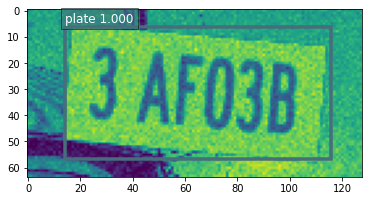

{'prediction': [[0.0, 0.9999861717224121, 0.01207086443901062, 0.09173271059989929, 0.977210283279419, 0.9079865217208862]]}


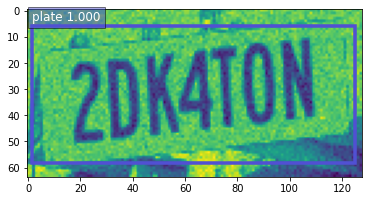

CPU times: user 2.18 s, sys: 0 ns, total: 2.18 s
Wall time: 4.05 s


In [32]:
%%time
for i in test_imgs[:10]:
    ifile = 'od/od-validation/' + i
    with open(ifile, "rb") as image:
        f = image.read()
        b = bytearray(f)
        results = object_detector.predict(b, initial_args={'ContentType': 'image/png'})
        detections = json.loads(results)
        print(detections)
    visualize_detection(ifile, detections['prediction'], 'plate', threshold)

## Endpoint API test

* You can invoke SageMaker endpoint from business application as below:

In [34]:
import boto3
runtime = boto3.Session().client('runtime.sagemaker')

In [35]:
od_endpoint = object_detector.endpoint_name
response = runtime.invoke_endpoint(EndpointName=od_endpoint,
                                   ContentType='image/png',
                                   Body=b)
response['Body']

In [36]:
test_result = response['Body'].read()

In [37]:
print(json.loads(test_result)['prediction'])

[[0.0, 0.9999861717224121, 0.01207086443901062, 0.09173271059989929, 0.977210283279419, 0.9079865217208862]]


## Delete endpoint

* Delete endpoint to avoid additional charges.

In [38]:
sagemaker.Session().delete_endpoint(object_detector.endpoint_name)

## Next step
Move to [Lab2](Lab2-custom-CNN-script-with-TF.ipynb) to develop a model to recongnize license plate characters.